# Raman Spectra Quality Control

## Setup

Import required packages

In [1]:
import os
import pandas as pd

from raman_lib.spectra_scoring import score_sort_spectra
from raman_lib.misc import load_data
from raman_lib.visualization import plot_spectra_peaks
from raman_lib.preprocessing import RangeLimiter, BaselineCorrector

Settings

In [2]:
# Name of the Dataset (for the output file)
name = "sersitive"

# Path where the data is stored
path = r"./data/sersitive daten/"

# Spectral range to analyze
# Use 'None' to use the whole range'
wn_min = None
wn_max = None

# QC settings - Choose either A or B and set the other to 'None'
# A)
n = 100 # How many spectra (per class) to keep (exactly this number - or less 
         # if a class does not contain enough spectra)
         
# B)
score_min = None # Minimum quality score that a spectrum must have to be kept.
n_min = None # Number of spectra that will be kept per class regardless of the score

# Window size for the Savitzky-Golay-Filter. Higher means stronger smoothing and less peaks found
sg_window = 50

# Threshold for the derivative. Higher means less peaks found.
threshold = 0.001

# Minimum height a peak must have to be detected
min_height = 50

# Plot baseline corrected (False) or raw spectra (True)
plot_raw = True

## Load Data

In [3]:
data = load_data(path)

print("Number of spectra per class:")
print(data.label.value_counts())

Number of spectra per class:
induziert 2        84
nicht induziert    63
Name: label, dtype: int64


## Scoring and Spectra Selection

In [4]:
data_new, deriv, score_dict = score_sort_spectra(data, 
                                                 n=n,
                                                 min_score=score_min, 
                                                 min_n=n_min,
                                                 limits=(wn_min, wn_max), 
                                                 sg_window=sg_window, 
                                                 threshold=threshold, 
                                                 min_height=min_height,
                                                 detailed=True)

print()
print("====================================")
print()
print("Number of spectra per class (after QC):")
print(data_new.label.value_counts())

Analyzed 147 spectra in 0.61 seconds.
Mean Score: 2048

1st Quartile: 258
Median Score: 1151
3rd Quartile: 2324

Min Score: 0
Max Score: 45463


Number of spectra per class (after QC):
induziert 2        84
nicht induziert    63
Name: label, dtype: int64


In [5]:
wns = data.drop(columns=["label", "file"]).columns
if plot_raw:
    data_plot = data.drop(columns=["label", "file"])
else:
    bl = BaselineCorrector()
    data_plot = bl.fit_transform(data.drop(columns=["label", "file"]))
    data_plot = pd.DataFrame(data_plot, columns=wns)

rl = RangeLimiter(lim=(wn_min, wn_max), 
                  reference=data_plot.columns)
data_plot = rl.fit_transform(data_plot)
wns_plot = data_plot.columns

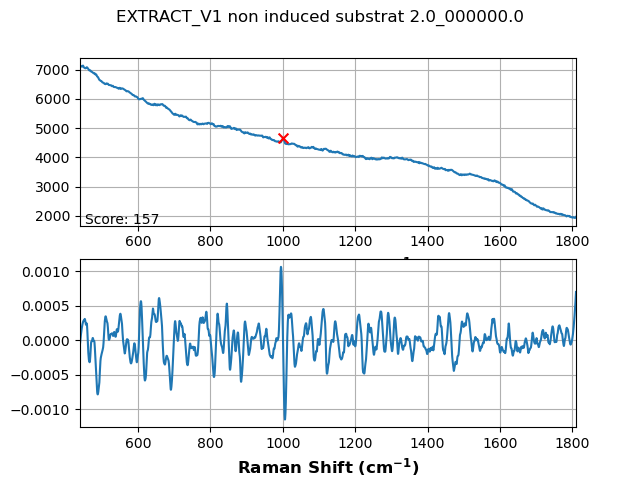

In [7]:
%matplotlib widget
plot_spectra_peaks(wns_plot, 
                   data_plot, 
                   deriv,
                   score_dict["peak_pos"],
                   score_dict["total_scores"],
                   labels=data.file)

## Export selected spectra

In [8]:
filename = name.lower().replace(" ", "_") + ".csv"

if not os.path.exists("./results_qc/"):
    os.mkdir("./results_qc/")

data_new.to_csv(os.path.join("./results_qc/", filename), index=False)

In [8]:
data

,label,file,440.0,440.5,441.0,441.5,442.0,442.5,443.0,443.5,...,1805.5,1806.0,1806.5,1807.0,1807.5,1808.0,1808.5,1809.0,1809.5,1810.0
0,nicht induziert,EXTRACT_V1 non induced substrat 2.0_000000.0,7148.088867,7143.726074,7137.961426,7130.531738,7122.274414,7114.604492,7109.023438,7105.837891,...,1941.631226,1938.102051,1933.395874,1930.985229,1932.243164,1935.807495,1941.397217,1950.148071,1960.553101,1966.658936
1,nicht induziert,EXTRACT_V1 non induced substrat 2.0_000022.0,8371.263672,8360.239258,8348.639648,8337.823242,8329.185547,8325.025391,8325.618164,8328.964844,...,2496.693359,2503.731934,2507.534180,2509.518799,2509.298340,2505.848145,2499.922363,2495.397217,2494.338379,2493.588623
2,nicht induziert,EXTRACT_V1 non induced substrat 3.0_000035.0,12774.747070,12770.420898,12772.793945,12779.810547,12786.609375,12789.471680,12788.809570,12787.328125,...,2561.113281,2550.753906,2543.073242,2543.778320,2551.241211,2556.836670,2555.107910,2548.739990,2542.784912,2536.168213
3,nicht induziert,EXTRACT_V1 non induced substrat 1.0_000000.0,11054.660156,11038.575195,11023.701172,11011.179688,11000.742188,10992.927734,10987.660156,10985.859375,...,2401.421143,2392.029053,2383.857910,2381.613525,2384.827148,2388.762695,2393.327637,2401.799072,2413.360107,2419.683105
4,nicht induziert,EXTRACT_V1 non induced substrat 1.0_000015.0,6722.608398,6717.233887,6711.461426,6705.956055,6701.316895,6698.732910,6698.329590,6700.166016,...,1925.489746,1923.162964,1922.372559,1923.670898,1924.639038,1922.942261,1919.630371,1919.373779,1923.787964,1927.860352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,induziert 2,EXTRACT_V1 sersitive 1.0_000022.0,1708.938354,1707.057739,1706.067383,1705.064453,1703.051880,1699.603394,1695.792603,1693.710571,...,657.707336,664.563843,667.679382,665.472656,659.295654,652.257507,647.522156,647.124939,649.298279,651.747986
143,induziert 2,EXTRACT_V1 sersitive 2.0_000022.0,1449.051147,1444.430176,1438.683960,1433.565552,1430.065552,1428.836182,1429.239990,1430.553589,...,439.370209,437.431427,434.675781,433.285889,434.326508,436.995544,439.421570,440.565948,440.820526,441.181580
144,induziert 2,EXTRACT_V1 sersitive 2.0_000037.0,1642.163208,1640.411621,1639.280762,1638.919067,1639.188843,1640.117554,1641.385620,1642.520508,...,479.116852,481.615417,484.122040,485.453217,484.603851,480.965454,475.648743,470.859741,468.885712,469.625885
145,induziert 2,EXTRACT_V1 sersitive 1.0_000014.0,1433.964600,1432.529419,1430.395264,1427.965088,1425.839844,1424.642944,1424.763794,1425.873047,...,476.506287,477.153656,477.230316,476.974060,476.564240,476.135712,475.899780,476.127777,476.661865,477.087616
